<a href="https://colab.research.google.com/github/LeeYuuuan/ECGR-5106-HW6/blob/main/ECGR_5106_HW6_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install torchinfo

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
from torchinfo import summary

In [5]:
class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, in_channels=3, embed_dim=256):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # [B, embed_dim, H', W']
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, embed_dim]
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, embed_dim,
                 num_heads, num_layers, mlp_dim, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(image_size, patch_size, 3, embed_dim)
        num_patches = (image_size // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.dropout = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([TransformerEncoder(embed_dim, num_heads, mlp_dim, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.dropout(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        return self.head(x[:, 0])

def train_with_val_loss(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - Val Acc: {val_accuracy:.2f}%")

    return train_losses, val_losses, val_accuracy


In [7]:
configs = [
    {"name": "A", "patch": 4, "embed": 256, "layers": 4, "heads": 2, "mlp": 512},
    {"name": "B", "patch": 4, "embed": 512, "layers": 8, "heads": 4, "mlp": 2048},

    {"name": "C", "patch": 8, "embed": 256, "layers": 4, "heads": 2, "mlp": 512},
    {"name": "D", "patch": 8, "embed": 512, "layers": 8, "heads": 4, "mlp": 2048},

    {"name": "E", "patch": 8, "embed": 256, "layers": 8, "heads": 4, "mlp": 512},
    {"name": "F", "patch": 8, "embed": 512, "layers": 8, "heads": 4, "mlp": 2048},

    {"name": "G", "patch": 8, "embed": 512, "layers": 4, "heads": 2, "mlp": 2048},
]

In [14]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_size = 32
batch_size = 64
num_epochs = 30
learning_rate = 0.001

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


results = []
loss_curves = {}

for cfg in configs:
    print(f"\n=== Training config {cfg['name']} ===")
    model = VisionTransformer(
        image_size=image_size,
        patch_size=cfg["patch"],
        num_classes=100,
        embed_dim=cfg["embed"],
        num_heads=cfg["heads"],
        num_layers=cfg["layers"],
        mlp_dim=cfg["mlp"]
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    start = time.time()
    train_losses, val_losses, val_acc = train_with_val_loss(
        model, train_loader, test_loader, criterion, optimizer, num_epochs)
    end = time.time()

    summary_stats = summary(model, input_size=(64, 3, 32, 32), verbose=0)

    results.append({
        "Name": cfg["name"],
        "Params": summary_stats.total_params,
        "Accuracy": val_acc,
        "TrainTime": round(end - start, 2)
    })
    loss_curves[cfg["name"]] = (train_losses, val_losses)





=== Training config A ===
Epoch [1/30] - Train Loss: 3.9641 - Val Loss: 3.7035 - Val Acc: 12.41%
Epoch [2/30] - Train Loss: 3.6518 - Val Loss: 3.5616 - Val Acc: 14.98%
Epoch [3/30] - Train Loss: 3.5269 - Val Loss: 3.4682 - Val Acc: 16.31%
Epoch [4/30] - Train Loss: 3.4165 - Val Loss: 3.3919 - Val Acc: 17.90%
Epoch [5/30] - Train Loss: 3.3886 - Val Loss: 3.3336 - Val Acc: 19.28%
Epoch [6/30] - Train Loss: 3.3140 - Val Loss: 3.2611 - Val Acc: 20.27%
Epoch [7/30] - Train Loss: 3.2293 - Val Loss: 3.2263 - Val Acc: 21.00%
Epoch [8/30] - Train Loss: 3.2105 - Val Loss: 3.1705 - Val Acc: 21.71%
Epoch [9/30] - Train Loss: 3.1614 - Val Loss: 3.1613 - Val Acc: 22.21%
Epoch [10/30] - Train Loss: 3.1470 - Val Loss: 3.1909 - Val Acc: 21.39%
Epoch [11/30] - Train Loss: 3.0900 - Val Loss: 3.1471 - Val Acc: 22.45%
Epoch [12/30] - Train Loss: 3.0568 - Val Loss: 3.0561 - Val Acc: 24.35%
Epoch [13/30] - Train Loss: 3.0374 - Val Loss: 3.0958 - Val Acc: 23.70%
Epoch [14/30] - Train Loss: 3.0493 - Val Loss:

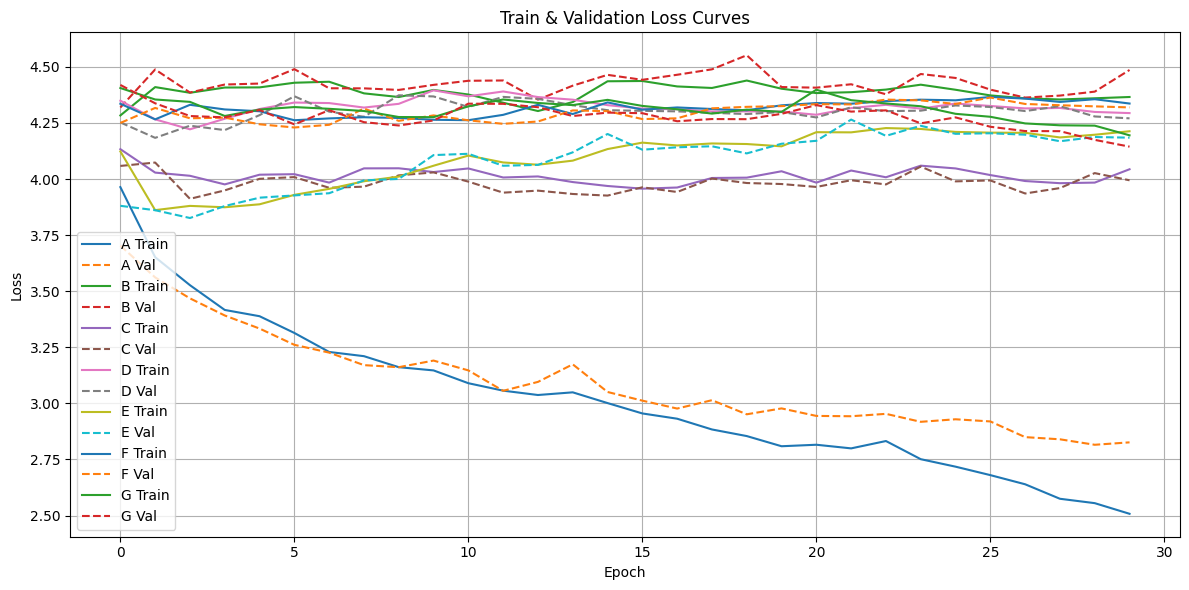

In [15]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 6))
for name, (train_l, val_l) in loss_curves.items():
    plt.plot(train_l, label=f'{name} Train')
    plt.plot(val_l, linestyle='--', label=f'{name} Val')
plt.title('Train & Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [16]:
# ====== Show Summary ======
import pandas as pd
import pprint
print("\n===== Final Results =====")
pprint.pprint(results)


===== Final Results =====
[{'Accuracy': 29.96, 'Name': 'A', 'Params': 2164068, 'TrainTime': 769.26},
 {'Accuracy': 2.87, 'Name': 'B', 'Params': 25330276, 'TrainTime': 1719.77},
 {'Accuracy': 8.87, 'Name': 'C', 'Params': 2188644, 'TrainTime': 768.96},
 {'Accuracy': 5.14, 'Name': 'D', 'Params': 25379428, 'TrainTime': 1070.08},
 {'Accuracy': 6.3, 'Name': 'E', 'Params': 4297060, 'TrainTime': 1061.46},
 {'Accuracy': 4.35, 'Name': 'F', 'Params': 25379428, 'TrainTime': 1086.53},
 {'Accuracy': 6.85, 'Name': 'G', 'Params': 12769892, 'TrainTime': 779.88}]


## Resnet 18

In [17]:
from torchvision.models import resnet18
from torchinfo import summary

model = resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 100)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train_resnet(model, train_loader, test_loader, num_epochs):
    train_losses = []
    val_losses = []
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc = 100 * correct / total
        val_losses.append(val_loss / len(test_loader))

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Val Loss: {val_losses[-1]:.4f} - Val Acc: {val_acc:.2f}%")

    end_time = time.time()
    elapsed_time = round(end_time - start_time, 2)

    return {
        "Params": summary(model, input_size=(64, 3, 32, 32), verbose=0).total_params,
        "Accuracy": val_acc,
        "TrainTime": elapsed_time,
        "TrainLosses": train_losses,
        "ValLosses": val_losses
    }

resnet_result = train_resnet(model, train_loader, test_loader, num_epochs)
print("\n=== ResNet-18 Summary ===")
print(resnet_result)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/30] - Train Loss: 3.5345 - Val Loss: 3.1648 - Val Acc: 23.02%
Epoch [2/30] - Train Loss: 2.7935 - Val Loss: 2.6085 - Val Acc: 33.47%
Epoch [3/30] - Train Loss: 2.3832 - Val Loss: 2.3907 - Val Acc: 38.90%
Epoch [4/30] - Train Loss: 2.0830 - Val Loss: 2.2313 - Val Acc: 42.29%
Epoch [5/30] - Train Loss: 1.8275 - Val Loss: 2.1883 - Val Acc: 42.68%
Epoch [6/30] - Train Loss: 1.5704 - Val Loss: 2.1965 - Val Acc: 44.42%
Epoch [7/30] - Train Loss: 1.3244 - Val Loss: 2.2708 - Val Acc: 44.83%
Epoch [8/30] - Train Loss: 1.0789 - Val Loss: 2.3504 - Val Acc: 45.01%
Epoch [9/30] - Train Loss: 0.8425 - Val Loss: 2.4896 - Val Acc: 45.66%
Epoch [10/30] - Train Loss: 0.6396 - Val Loss: 2.6666 - Val Acc: 45.12%
Epoch [11/30] - Train Loss: 0.4882 - Val Loss: 2.8774 - Val Acc: 44.05%
Epoch [12/30] - Train Loss: 0.3833 - Val Loss: 3.0885 - Val Acc: 44.60%
Epoch [13/30] - Train Loss: 0.3286 - Val Loss: 3.2413 - Val Acc: 44.86%
Epoch [14/30] - Train Loss: 0.2836 - Val Loss: 3.3251 - Val Acc: 44.10%
E

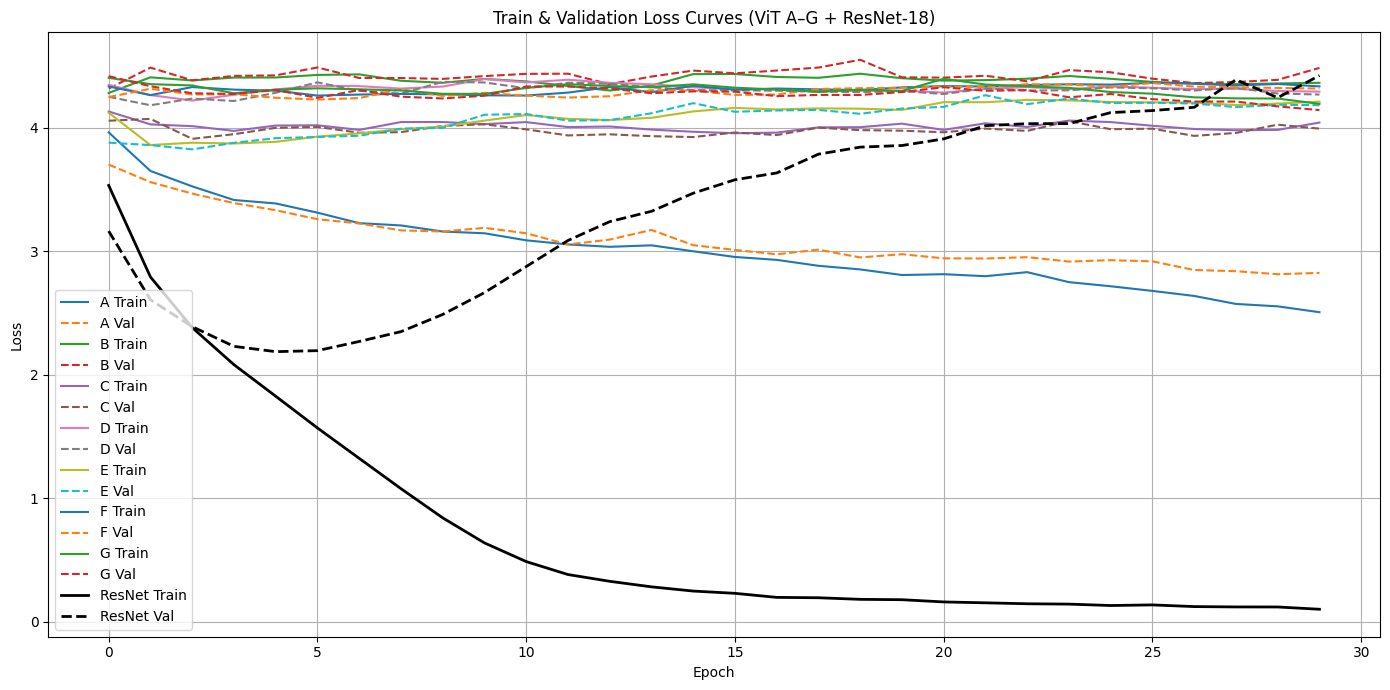

In [19]:
import matplotlib.pyplot as plt

# 你已有的 loss_dict（ViT 配置）
# loss_curves = {'A': (train_loss_list, val_loss_list), ...}  # 示例结构

# ResNet 的 loss（你刚发的）
resnet_train_loss = resnet_result['TrainLosses']
resnet_val_loss = resnet_result['ValLosses']
# 原 ViT loss 曲线绘制（假设你之前已经准备好了 loss_curves）
plt.figure(figsize=(14, 7))

for name, (train_loss, val_loss) in loss_curves.items():
    plt.plot(train_loss, label=f"{name} Train")
    plt.plot(val_loss, linestyle='--', label=f"{name} Val")

# 添加 ResNet-18 曲线
plt.plot(resnet_train_loss, label="ResNet Train", linewidth=2, color="black")
plt.plot(resnet_val_loss, linestyle='--', label="ResNet Val", linewidth=2, color="black")

plt.title("Train & Validation Loss Curves (ViT A–G + ResNet-18)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("all_loss_curve_with_resnet.png", dpi=300)
plt.show()
